# Model development

This is the notebook where I am currently experimenting with different ML models to predict new covid cases / deaths. 

First, run the script to load and process the data

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
import pandas as pd

# import covid_data_script
%run covid_data.py

covid data script loaded


In [2]:
# retrieve and load the cleaned data
df, df2 = retrieve_data(load_local=True)

# preprocess df2
df2_preprocessed = prep_policy_data(df2)

C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Models and Hyperparameters to explore: 

**Machine Learning Models**

- Linear Regression
- Ridge Regression
- Lasso Regression
- ElasticNet
- Stochastic Gradient Descent
- Decision Tree
- Random Forest

**Machine learning models that I'm not familiar with but might want to try**
- XGBoost

**Neural networks**
- Multilayer Perceptron
- Convolutional NN? (update 2/19: CNN wouldn't make sense for this application)

Technically, this is time-series data, but I'm not currently *processing* this as time series data. 

**The Big Issue**: According to best practice, one should do the train-test split before any kind of work with model selection (to prevent overfitting and picking up patterns that are actually random). This problem is that the primary feature engineering step requires the Full dataset -> this probably means I need to change the way I'm implementing the feature engineering. 

**Possible solution**: Instead of using scikit-learn's implementation of the train_test split, implement my own but do the split by a random selection of counties. This means that data from different points in the pandemic, but from the same county, will either all be in the test set or all in the train set. Do the same thing for K-fold cross validation.

**Final note**: Also try RNN-LSTM

# Feature engineering on training set only

- All this will go into a function once I know what I'm doing

Now that we have the split, apply the feature engineering

In [19]:
def county_split(df, test_size, split_type="train_test"):
    """
    
    """
    
    all_counties = df['full_loc_name'].unique()

    # shuffle the list
    np.random.shuffle(all_counties)

    # split the data
    counties_test = all_counties[: int(len(all_counties)*test_size)]
    counties_train = all_counties[int(len(all_counties)*test_size) :]

    df_test = df[df['full_loc_name'].isin(counties_test)]
    df_train = df[df['full_loc_name'].isin(counties_train)]
    
    return df_test, df_train

In [77]:
import os

def train_model_cv(df_train_proc, model_in, metrics_dict, K=10, verbose=True, save_output=True, filename="log.txt"):
    """Function to train models using K-fold cross validation
    Parameters
    -----------
    df_train_proc: DataFrame
        processed dataframe (after selecting bins and joining with cases)
    model_in: call to an sklearn object
        call to the models constructor method
    K: integer
        number of cross-validation folds
    verbose: Boolean
        detailed outputs
    
    """
    results_dict = {metric: [] for metric in metrics_dict.keys()}

    counties = df_train_proc[('info', 'full_loc')].unique()

    # shuffle the counties
    np.random.shuffle(counties)
    batch_size = int(len(counties) / K)
    
    msg1 = f"number of cross-validation folds: {K}"
    msg2 = f"num counties in validation set: {batch_size}"
    
    if verbose: 
        print(msg1)
        print(msg2)
    if save_output: 
        with open(filename, "a") as log: 
            log.write(msg1)
            log.write(msg2)

    for k in range(K): 
        # select the train and validation portion
        df_train = df_train_proc[~df_train_proc[
            ('info', 'full_loc')].isin(counties[k*batch_size:(k+1)*batch_size])]
        df_validate = df_train_proc[df_train_proc[
            ('info', 'full_loc')].isin(counties[k*batch_size:(k+1)*batch_size])]

        # Implement and train the model
        X_train = df_train.loc[:, df_train.columns[5:]].values
        y_train = df_train.loc[:, ('info', 'new_cases_1e6')].values 

        X_validate = df_validate.loc[:, df_validate.columns[5:]].values
        y_validate = df_validate.loc[:, ('info', 'new_cases_1e6')].values

        model = model_in
        model.fit(X_train, y_train)

        # compute scores
        for metric in metrics_dict.keys():
            score = metrics_dict[metric](y_validate, model.predict(X_validate))
            results_dict[metric].append(score)
        
        results = [(str(metric) + ": " + str(results_dict[metric][k])) for metric in metrics_dict.keys()]
        
        msg = f"fold: {k}, scores: {results}"
        if verbose: 
            print(msg)
        if save_output: 
            with open(filename, "a") as log: 
                log.write(msg)

    return results_dict, model.get_params()

def loop_models(df_train_proc, models_dict, metrics_dict, K=10, verbose=True, save_output=True, filename="log.txt"): 
    
    # declare an empty dictionary to hold all results
    results = {}
    
    # loop through all the models passed
    for model in models_dict.keys():
        msg = f"running models: {model}"
        if verbose: 
            print(msg)
        if save_output: 
            with open(filename, "a") as log: 
                log.write(msg)

        # declare empty dictionary for results from this one run
        model_results = {}
        scores, params = train_model_cv(df_train_proc=df_train_proc, 
                                     model_in=models_dict[model], 
                                     metrics_dict=metrics_dict, 
                                     K=K, 
                                     verbose=verbose, 
                                     save_output=save_output, 
                                     filename=filename)
        
        # save the results in a dictionary
        model_results['params'] = params
        model_results['scores'] = scores
        
        results[model] = model_results
    return results

def run_batch(df_train, df2_preprocessed, bins_dict, models_dict, metrics_dict, K=10, verbose=True,
                        save_output=True, filename="log.txt", overwrite=True, output_json=True,
                        json_file="results.json"): 
    
    results = {}
    
    if overwrite & os.path.exists(filename): 
        os.remove(filename)
    
    for i, key in enumerate(bins_dict):
        bins_list = bins_dict[key]
        
        msg = f"bins: {bins_list}"
        if verbose: 
            print(msg)
        if save_output: 
            with open(filename, "a") as log: 
                log.write(msg)
                
        df_train_proc = join_policies(case_df=df_train, 
                                      policy_df=df2_preprocessed, 
                                      output=True, 
                                      bins_list=bins_list, 
                                      state_output=False)
        
        models_results = loop_models(df_train_proc=df_train_proc, 
                                    models_dict=models_dict,
                                    metrics_dict=metrics_dict, 
                                    K=K,
                                    verbose=verbose, 
                                    save_output=save_output, 
                                    filename=filename)
        models_results['bins'] = bins_list
        
        results[key] = models_results
    
    if output_json: 
        if overwrite & os.path.exists(json_file): 
            os.remove(json_file)
        with open(json_file, 'w') as file: 
            json.dump(results, file)
        
    
    return results    

In [24]:
bins_dict = {
    1: [(0, 3), (4, 10), (11, 999)], 
    2: [(0, 5), (6, 20), (21, 999)], 
    3: [(0, 10), (11, 30), (31, 60), (61, 100), (101, 999)]
}

models_dict = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(), 
    'Lasso': Lasso(), 
    'ElasticNet': ElasticNet(), 
    'DecisionTree': DecisionTreeRegressor(), 
    'Random Forest (n=10)': RandomForestRegressor(n_estimators=10)
}

metrics_dict = {
    'R^2': r2_score,
    'MSE': mean_squared_error, 
    'Explained_var': explained_variance_score
}



results = run_features_models(df_train, df2_preprocessed, bins_dict, models_dict, metrics_dict, K=10, verbose=True, 
                             save_output=True, filename="runs_219.txt", overwrite=True, output_json=True)

bins: [(0, 3), (4, 10), (11, 999)]
data shaped
bins: [(0, 3), (4, 10), (11, 999)]
time elapsed: 85.98365259170532
running models: OLS
number of cross-validation folds: 10
num counties in validation set: 251
fold: 0, scores: ['R^2: 0.10396881137860547', 'MSE: 2550.9129522768876', 'Explained_var: 0.1043034546375009']
fold: 1, scores: ['R^2: 0.09366023600108875', 'MSE: 2796.264575345405', 'Explained_var: 0.09376037222102762']
fold: 2, scores: ['R^2: 0.09234292023342905', 'MSE: 2683.1910448921426', 'Explained_var: 0.0923895406619234']
fold: 3, scores: ['R^2: 0.07207637190427763', 'MSE: 3267.743446432535', 'Explained_var: 0.07208684885455707']
fold: 4, scores: ['R^2: 0.09686945626546262', 'MSE: 2581.96302854686', 'Explained_var: 0.09690878153181792']
fold: 5, scores: ['R^2: 0.07863474915984348', 'MSE: 3144.736526067711', 'Explained_var: 0.07863777477743894']
fold: 6, scores: ['R^2: -3.3121905907146387e+19', 'MSE: 1.1366877482335908e+23', 'Explained_var: -3.30354889336162e+19']
fold: 7, scor

fold: 6, scores: ['R^2: 0.08667882582528663', 'MSE: 2986.5527490147915', 'Explained_var: 0.08668273778912972']
fold: 7, scores: ['R^2: 0.09300984128302714', 'MSE: 2797.0670186026787', 'Explained_var: 0.09300984932115797']
fold: 8, scores: ['R^2: 0.10644847300598415', 'MSE: 2431.5268006957167', 'Explained_var: 0.10669145973052008']
fold: 9, scores: ['R^2: 0.10944838950245528', 'MSE: 2460.9789486159657', 'Explained_var: 0.10949220448026442']
running models: Ridge
number of cross-validation folds: 10
num counties in validation set: 251
fold: 0, scores: ['R^2: 0.07855140537966898', 'MSE: 3098.6366175036987', 'Explained_var: 0.07904005702492933']
fold: 1, scores: ['R^2: 0.08758668875997966', 'MSE: 3124.634172601566', 'Explained_var: 0.08758768644231696']
fold: 2, scores: ['R^2: 0.08836151585871588', 'MSE: 3376.3930157617797', 'Explained_var: 0.08850507195078172']
fold: 3, scores: ['R^2: 0.10045716869053734', 'MSE: 2539.2777716705727', 'Explained_var: 0.10045834044744395']
fold: 4, scores: [

fold: 3, scores: ['R^2: 0.168537201913027', 'MSE: 2132.4739179022213', 'Explained_var: 0.16853837115635917']
fold: 4, scores: ['R^2: 0.11865781310852785', 'MSE: 3298.632217583842', 'Explained_var: 0.1186916438558332']
fold: 5, scores: ['R^2: 0.11552829827840849', 'MSE: 3262.875408563593', 'Explained_var: 0.11571416861118078']
fold: 6, scores: ['R^2: 0.10305534044667786', 'MSE: 3979.283671080918', 'Explained_var: 0.10327825104430399']
fold: 7, scores: ['R^2: 0.17392782664921114', 'MSE: 2046.183345112512', 'Explained_var: 0.17398875943303138']
fold: 8, scores: ['R^2: 0.14677241252369522', 'MSE: 2656.6683143066175', 'Explained_var: 0.14677634176881837']
fold: 9, scores: ['R^2: 0.1427119984878471', 'MSE: 2794.765579707611', 'Explained_var: 0.14271490417242572']
running models: Lasso
number of cross-validation folds: 10
num counties in validation set: 251
fold: 0, scores: ['R^2: 0.15970426551226646', 'MSE: 1919.4530672835042', 'Explained_var: 0.1599505230718109']
fold: 1, scores: ['R^2: 0.0

## Figure out how to visualize these results

In [150]:
def plot_metrics(results, bin_id, bins_dict, model_id, metrics_dict, ax_limits):
    
    fig, ax = plt.subplots(ncols=len(metrics_dict.keys()), figsize=[12, 3])
    fig.suptitle(f"bins: {bins_dict[bin_id]}\nmodel: {model_id}", y=1.1)
    for i, metric_id in enumerate(metrics_dict.keys()):

        nums = results[str(bin_id-1)][model_id]['scores'][metric_id]

        ax[i].scatter(range(len(nums)), nums)
        ax[i].set_ylim(ax_limits[metric_id])
        title = f"{metric_id}"
        ax[i].set_title(title)
        
def plot_models(results, bin_id, bins_dict, models_dict, ax_limits):
    
    for model in models_dict.keys(): 
        plot_metrics(results, bin_id, bins_dict, model, metrics_dict, ax_limits)
        
def plot_bins(results, bins_dict, models_dict, ax_limits): 
    
    for bin_id in [1, 2, 3]: 
        plot_models(results, bin_id, bins_dict, models_dict, ax_limits)

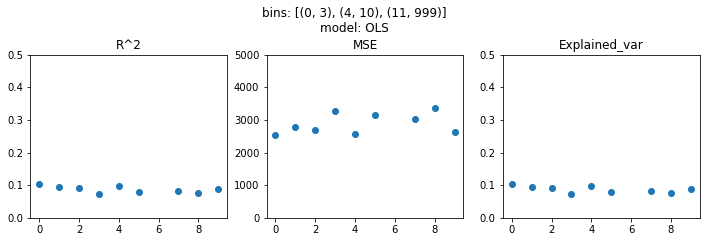

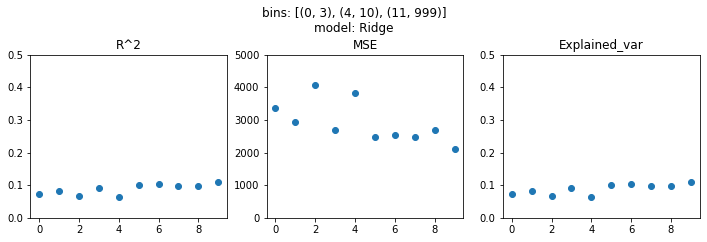

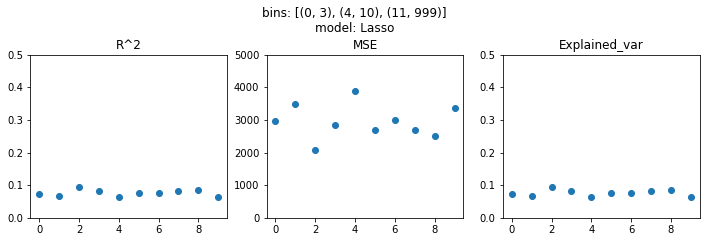

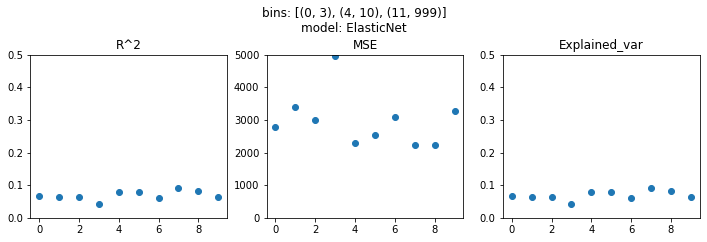

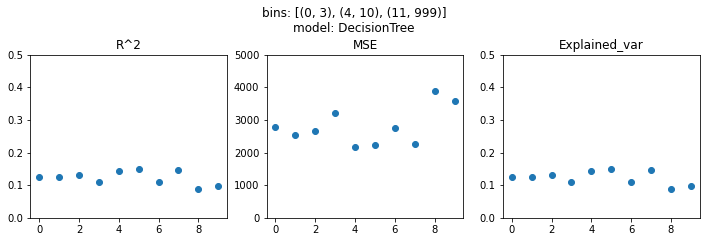

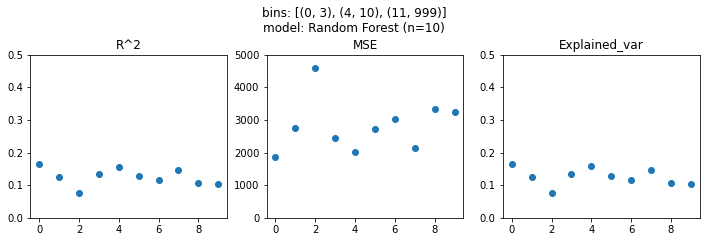

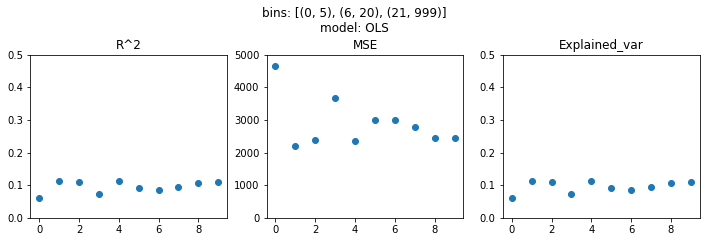

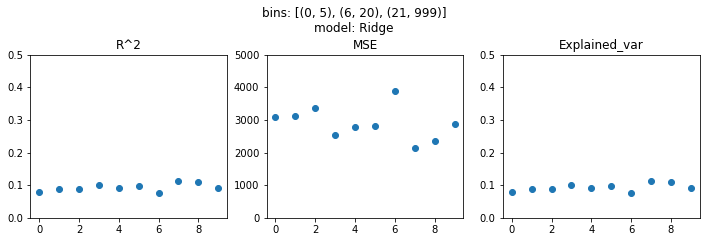

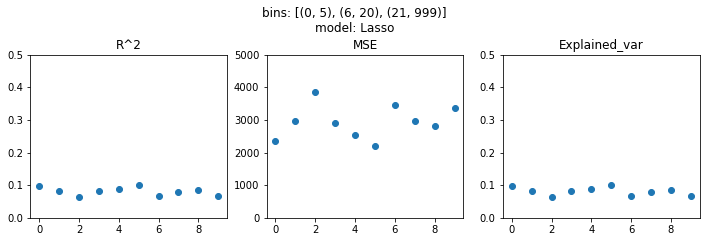

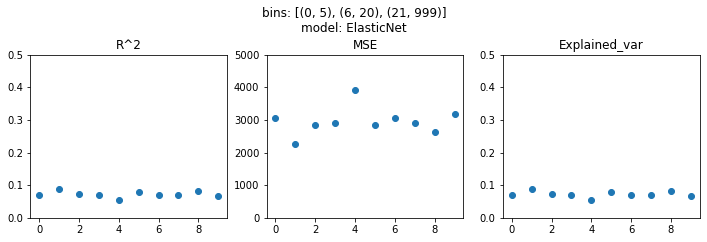

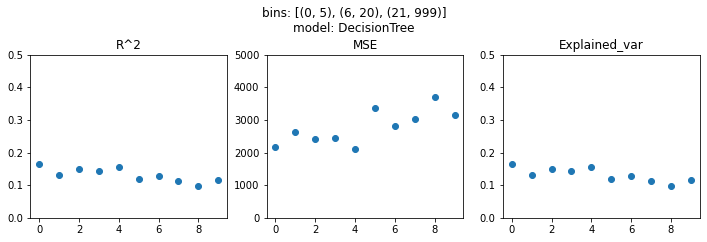

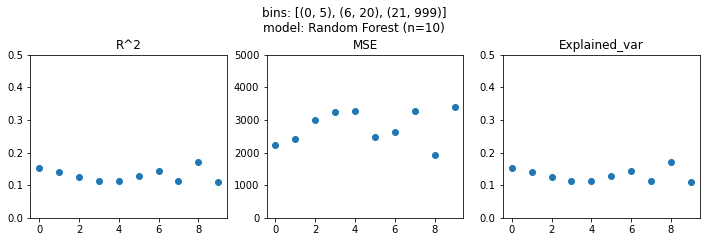

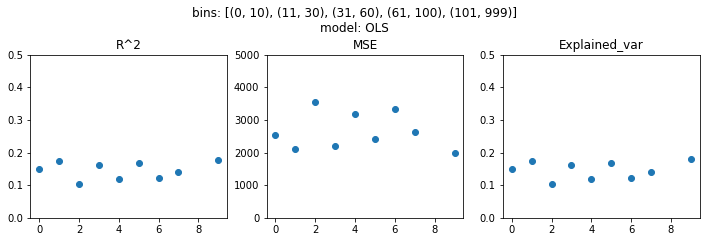

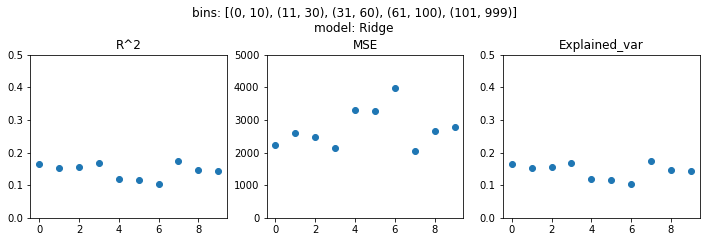

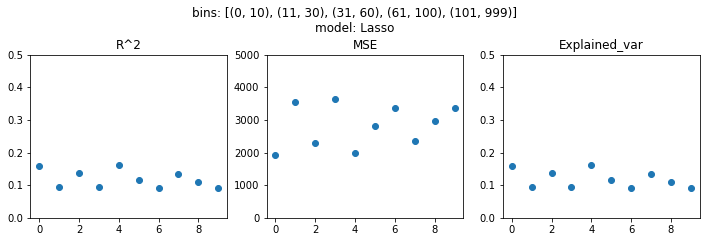

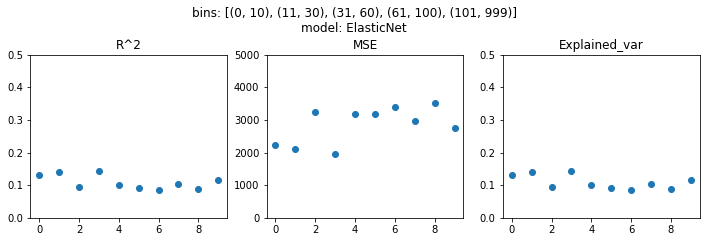

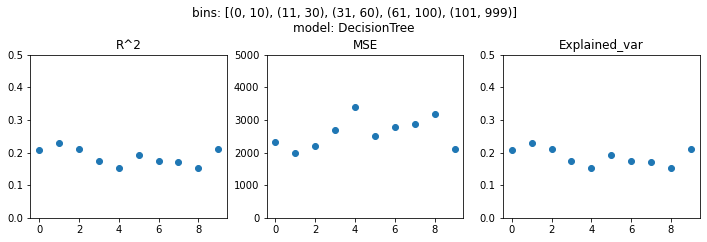

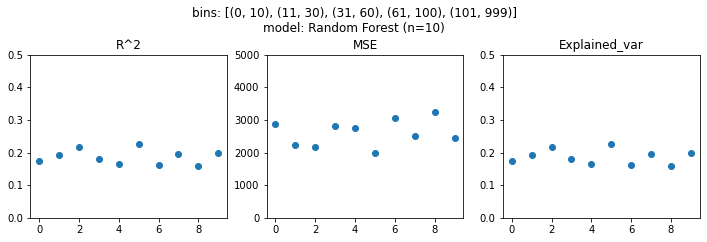

In [151]:
filename="results_219_json.txt"
with open(filename, 'r') as file:
    results = json.load(file)
    
ax_limits = {
    'R^2': [0, 0.5], 
    'MSE': [0, 5000], 
    'Explained_var': [0, 0.5]
}

        
plot_bins(results, bins_dict, models_dict, ax_limits)

# Simplifying model outputs

In [ ]:
def train_model_cv(df_train_proc, model_key, model_in, metrics_dict, results_df, bin_id
                   K=10, verbose=True, save_output=True, filename="log.txt", ):
    """Function to train models using K-fold cross validation
    Parameters
    -----------
    df_train_proc: DataFrame
        processed dataframe (after selecting bins and joining with cases)
    model_in: call to an sklearn object
        call to the models constructor method
    K: integer
        number of cross-validation folds
    verbose: Boolean
        detailed outputs
    
    """
    results_dict = {metric: [] for metric in metrics_dict.keys()}

    counties = df_train_proc[('info', 'full_loc')].unique()

    # shuffle the counties
    np.random.shuffle(counties)
    batch_size = int(len(counties) / K)
    
    msg1 = f"number of cross-validation folds: {K}"
    msg2 = f"num counties in validation set: {batch_size}"
    
    if verbose: 
        print(msg1)
        print(msg2)
    if save_output: 
        with open(filename, "a") as log: 
            log.write(msg1)
            log.write(msg2)

    for k in range(K): 
        # select the train and validation portion
        df_train = df_train_proc[~df_train_proc[
            ('info', 'full_loc')].isin(counties[k*batch_size:(k+1)*batch_size])]
        df_validate = df_train_proc[df_train_proc[
            ('info', 'full_loc')].isin(counties[k*batch_size:(k+1)*batch_size])]

        # Implement and train the model
        X_train = df_train.loc[:, df_train.columns[5:]].values
        y_train = df_train.loc[:, ('info', 'new_cases_1e6')].values 

        X_validate = df_validate.loc[:, df_validate.columns[5:]].values
        y_validate = df_validate.loc[:, ('info', 'new_cases_1e6')].values

        model = model_in
        model.fit(X_train, y_train)

        # compute scores
        for metric in metrics_dict.keys():
            score = metrics_dict[metric](y_validate, model.predict(X_validate))
            results_dict[metric].append(score)
            results_df.loc[(metric, k), (bin_id, )]
            
        results = [(str(metric) + ": " + str(results_dict[metric][k])) for metric in metrics_dict.keys()]
        
        msg = f"fold: {k}, scores: {results}"
        if verbose: 
            print(msg)
        if save_output: 
            with open(filename, "a") as log: 
                log.write(msg)

    return results_dict, model.get_params()

def loop_models(df_train_proc, models_dict, metrics_dict, bin_id, K=10, verbose=True, save_output=True, 
                filename="log.txt", results_df=results_df): 
    """Loop through each model. """
    # declare an empty dictionary to hold all results
    results = {}
    
    # loop through all the models passed
    for model in models_dict.keys():
        msg = f"running models: {model}"
        if verbose: 
            print(msg)
        if save_output: 
            with open(filename, "a") as log: 
                log.write(msg)

        # declare empty dictionary for results from this one run
        model_results = {}
        scores, params = train_model_cv(df_train_proc=df_train_proc, 
                                     model_in=models_dict[model], 
                                     metrics_dict=metrics_dict, 
                                     bin_id=bin_id,
                                     K=K, 
                                     verbose=verbose, 
                                     save_output=save_output, 
                                     filename=filename, 
                                     results_df=results_df)
        
        # save the results in a dictionary
        model_results['params'] = params
        model_results['scores'] = scores
        
        results[model] = model_results
        
    return results


def run_batch(df_train, 
              df2_preprocessed,
              bins_dict,
              models_dict,
              metrics_dict,
              K=10,
              verbose=True,
              save_output_log=True,
              save_json_output=True,
              log_file="log.txt",
              json_file="results.json"
              overwrite=True): 
    
    """For each set of bins, loop through every model and do cross validation. 
    Parameters
    -----------
    df_train: DataFrame
    df2_preprocessed: DataFrame
    bins_dict: dictionary
    models_dict: dictionary
    metrics_dict: dictionary
    K: integer
    verbose: boolean
    save_output_log:boolean
    
    
    """
    
    # Initialize dictionary for results (for json outputs)
    results = {}
    
    # Initialize multi-index DataFrame for results
    all_bins = list(bins_dict.keys())
    models = list(models_dict.keys())
    metrics = list(metrics_dict.keys())
    cols = pd.MultiIndex.from_product([all_bins, models], names=["bin id", "model"])
    index = pd.MultiIndex.from_product([metrics, range(K)], names=["metric", "sample"])
    results_df = pd.DataFrame(columns=cols, index=index)
    
    # Delete old log files if overwritting and the file already exists
    if overwrite & os.path.exists(log_file): 
        os.remove(log_file)
    if overwrite & os.path.exists(json_file):
        os.remove(json_file)
    
    # loop through all bin types
    for i, key in enumerate(bins_dict):
        bins_list = bins_dict[key]
        
        msg = f"bins: {bins_list}"
        if verbose: 
            print(msg)
        if save_output_log: 
            with open(log_file, "a") as log: 
                log.write(msg)
                
        df_train_proc = join_policies(case_df=df_train, 
                                      policy_df=df2_preprocessed, 
                                      output=True, 
                                      bins_list=bins_list, 
                                      state_output=False)
        
        models_results, results_df = loop_models(df_train_proc=df_train_proc, 
                                    models_dict=models_dict,
                                    bin_id=key,
                                    metrics_dict=metrics_dict, 
                                    K=K,
                                    verbose=verbose, 
                                    save_output=save_output_log, 
                                    filename=filename, 
                                    results_df=results_df)
        
        models_results['bins'] = bins_list
        
        results[key] = models_results
    
    if save_json_output: 
        if overwrite & os.path.exists(json_file): 
            os.remove(json_file)
            
        with open(json_file, 'w') as file: 
            json.dump(results, file)
        
    
    return results_df

Idea: try using a multiIndexed dataframe to store all the results
- rows = metric -> each fold of validation
- columns = bin -> model

In [188]:
K = 10 # use number of cross-folds to generate dataframe
results_df

bin id                  1                                      \
model                 OLS Ridge Lasso ElasticNet DecisionTree   
metric        sample                                            
R^2           0       NaN   NaN   NaN        NaN          NaN   
              1       NaN   NaN   NaN        NaN          NaN   
              2       NaN   NaN   NaN        NaN          NaN   
              3       NaN   NaN   NaN        NaN          NaN   
              4       NaN   NaN   NaN        NaN          NaN   
              5       NaN   NaN   NaN        NaN          NaN   
              6       NaN   NaN   NaN        NaN          NaN   
              7       NaN   NaN   NaN        NaN          NaN   
              8       NaN   NaN   NaN        NaN          NaN   
              9       NaN   NaN   NaN        NaN          NaN   
MSE           0       NaN   NaN   NaN        NaN          NaN   
              1       NaN   NaN   NaN        NaN          NaN   
              2       NaN   NaN   NaN        NaN          NaN   
              3       NaN   NaN   NaN        NaN          NaN   
              4       NaN   NaN   NaN        NaN          NaN   
              5       NaN   NaN   NaN        NaN          NaN   
              6       NaN   NaN   NaN        NaN          NaN   
              7       NaN   NaN   NaN        NaN          NaN   
              8       NaN   NaN   NaN        NaN          NaN   
              9       NaN   NaN   NaN        NaN          NaN   
Explained_var 0       NaN   NaN   NaN        NaN          NaN   
              1       NaN   NaN   NaN        NaN          NaN   
              2       NaN   NaN   NaN        NaN          NaN   
              3       NaN   NaN   NaN        NaN          NaN   
              4       NaN   NaN   NaN        NaN          NaN   
              5       NaN   NaN   NaN        NaN          NaN   
              6       NaN   NaN   NaN        NaN          NaN   
              7       NaN   NaN   NaN        NaN          NaN   
              8       NaN   NaN   NaN        NaN          NaN   
              9       NaN   NaN   NaN        NaN          NaN   

bin id                                       2                         \
model                Random Forest (n=10)  OLS Ridge Lasso ElasticNet   
metric        sample                                                    
R^2           0                       NaN  NaN   NaN   NaN        NaN   
              1                       NaN  NaN   NaN   NaN        NaN   
              2                       NaN  NaN   NaN   NaN        NaN   
              3                       NaN  NaN   NaN   NaN        NaN   
              4                       NaN  NaN   NaN   NaN        NaN   
              5                       NaN  NaN   NaN   NaN        NaN   
              6                       NaN  NaN   NaN   NaN        NaN   
              7                       NaN  NaN   NaN   NaN        NaN   
              8                       NaN  NaN   NaN   NaN        NaN   
              9                       NaN  NaN   NaN   NaN        NaN   
MSE           0                       NaN  NaN   NaN   NaN        NaN   
              1                       NaN  NaN   NaN   NaN        NaN   
              2                       NaN  NaN   NaN   NaN        NaN   
              3                       NaN  NaN   NaN   NaN        NaN   
              4                       NaN  NaN   NaN   NaN        NaN   
              5                       NaN  NaN   NaN   NaN        NaN   
              6                       NaN  NaN   NaN   NaN        NaN   
              7                       NaN  NaN   NaN   NaN        NaN   
              8                       NaN  NaN   NaN   NaN        NaN   
              9                       NaN  NaN   NaN   NaN        NaN   
Explained_var 0                       NaN  NaN   NaN   NaN        NaN   
              1                       NaN  NaN   NaN   NaN        NaN   
              2              

In [166]:
def build_results_df(results, metric): 
    
    for bin_id in results.keys():
        for model_id in results[bin_id].keys(): 
            print(model_id)
    
build_results_df(results, "R^2)")

OLS
Ridge
Lasso
ElasticNet
DecisionTree
Random Forest (n=10)
bins
OLS
Ridge
Lasso
ElasticNet
DecisionTree
Random Forest (n=10)
bins
OLS
Ridge
Lasso
ElasticNet
DecisionTree
Random Forest (n=10)
bins


# Copied some stuff from script file

In [ ]:
def run_batch(df_train,
              df2_preprocessed,
              bins_dict,
              models_dict,
              metrics_dict,
              K=10,
              verbose=True,
              save_out_log=True,
              save_json_output=True,
              log_file="log.txt",
              json_file="results.json",
              overwrite=True):
    """For each set of bins, loop through every model and do cross validation.
    Parameters
    -----------
    df_train: DataFrame
        Processed training dataframe with case info
    df2_preprocessed: DataFrame
        Processed policy dataframe
    bins_dict: dictionary
        dictionary of bins: key=id, value=list of bins
    models_dict: dictionary
        dictionary of models: key=id, value=constructor
    metrics_dict: dictionary
        dictionary of metrics to measure performance: key=id, value=method call
    K: integer
        Number of folds for cross-validation
    verbose: boolean
        If true, output details to console
    save_out_log: boolean
        If true, save the results of verbose output to a text file
    save_json_output: boolean
        If true, save the final results to a json file
    log_file: string (filepath)
        File path to log output file
    json_file: string (filepath)
        File path to json output file
    overwrite: boolean
        If true, delete output logs if names overlap
        (avoids accidental overwritting)
    Returns
    ----------
    results_df: DataFrame
        multi-indexed DataFrame with all metrics
    """

    # Initialize dictionary for results (for json outputs).
    results = {}

    # Initialize multi-index DataFrame for results.
    all_bins = list(bins_dict.keys())
    models = list(models_dict.keys())
    metrics = list(metrics_dict.keys())

    cols = pd.MultiIndex.from_product(
        [all_bins, models], names=["bin id", "model"])
    index = pd.MultiIndex.from_product(
        [metrics, range(K)], names=["metric", "sample"])

    results_df = pd.DataFrame(columns=cols, index=index)

    # Delete old log files if overwritting and the file already exists.
    if overwrite & os.path.exists(log_file):
        os.remove(log_file)
    if overwrite & os.path.exists(json_file):
        os.remove(json_file)

    # loop through all bin types.
    for i, bin_id in enumerate(bins_dict):
        bins_list = bins_dict[bin_id]

        # Output to console and/or log file.
        msg = "bins: {}".format(bins_list)
        if verbose:
            print(msg)
        if save_out_log:
            with open(log_file, "a") as log:
                log.write(msg)

        # Feature engineering with the selected bins.
        df_train_proc = join_policies(case_df=df_train,
                                      policy_df=df2_preprocessed,
                                      output=True,
                                      bins_list=bins_list,
                                      state_output=False)

        # Train all models for the given bin
        model_results, results_df = loop_models(df_train_proc=df_train_proc,
                                                results_df=results_df,
                                                models_dict=models_dict,
                                                metrics_dict=metrics_dict,
                                                bin_id=bin_id,
                                                K=K,
                                                verbose=verbose,
                                                save_out_log=save_out_log,
                                                log_file=log_file)

        # Add the dictionary of results to master dictionary
        model_results['bins'] = bins_list
        results[bin_id] = model_results

    # Save the json output
    if save_json_output:
        if overwrite & os.path.exists(json_file):
            os.remove(json_file)

        with open(json_file, 'w') as file:
            json.dump(results, file)

    # Return the results dataframe
    return results_df

In [ ]:
def loop_models(df_train_proc,
                results_df,
                models_dict,
                metrics_dict,
                bin_id,
                K=10,
                verbose=True,
                save_out_log=True,
                log_file="log.txt"):
    """Loop through and train each model.
    Parameters
    -----------
    df_train_proc: DataFrame
        Processed dataframe with features and targets
    results_df: DataFrame
        MultiIndex dataframe summarizing results
    models_dict: dictionary
        dictionary of models: key=id, value=constructor
    metrics_dict: dictionary
        dictionary of metrics to measure performance: key=id, value=method call
    bin_id: integer
        unique ID of bin distrubution (use for outputs and logging)
    K: integer
        Number of folds for cross-validation
    verbose: boolean
        If true, output details to console
    save_out_log: boolean
        If true, save the results of verbose output to a text file
    log_file: string (filepath)
        File path to log output file
    Returns
    -----------
    results: dictionary
    results_df: DataFrame
    """

    # declare an empty dictionary to hold results
    results = {}

    # loop through all the models passed
    for model_id in models_dict.keys():

        # Output status.
        msg = f"running models: {model_id}"
        if verbose:
            print(msg)
        if save_out_log:
            with open(log_file, "a") as log:
                log.write(msg)

        # declare empty dictionary for results from this one run
        model_results = {}
        scores, params = train_model_cv(df_train_proc=df_train_proc,
                                        results_df=results_df,
                                        model_id=model_id,
                                        model=models_dict[model_id],
                                        metrics_dict=metrics_dict,
                                        bin_id=bin_id,
                                        K=K,
                                        verbose=verbose,
                                        save_out_log=save_out_log,
                                        log_file=log_file,)

        # save the results in a dictionary
        model_results['params'] = params
        model_results['scores'] = scores
        results[model_id] = model_results

    return results, results_df